전처리 방식 수정 (다른 필터들 적용)

In [2]:
# pip install biosppy nolds scikit-learn peakutils

In [1]:
import wfdb
import numpy as np
import pandas as pd
import glob
import os
from wfdb import rdrecord
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from scipy import signal, fft
from scipy.signal import spectrogram
from biosppy.signals.ecg import christov_segmenter, hamilton_segmenter
from nolds import sampen
from sklearn.impute import SimpleImputer

2025-03-27 15:06:15.251353: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 15:06:15.252646: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 15:06:15.256511: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 15:06:15.266381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743087975.282460      30 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743087975.28

### 함수 정의

In [67]:
import numpy as np
import pandas as pd
import pywt
import wfdb
from wfdb.processing import gqrs_detect
from scipy.signal import butter, filtfilt, welch, find_peaks
from scipy.stats import entropy
from multiprocessing import Pool, cpu_count
from sklearn.impute import SimpleImputer
import time
import scipy.ndimage
from scipy.stats import skew, kurtosis
from tqdm import tqdm

In [69]:
# ✅ 웨이블릿 기반 노이즈 제거

def wavelet_denoise(signal, wavelet='db6', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.median(np.abs(coeffs[-1])) / 0.6745
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

# ✅ 형태학적 필터를 이용한 기저선 제거

def oc_co_filter(signal, fs, k_factor):
    k_size = int(np.round(k_factor * fs))
    struct_elem = np.ones(k_size)
    opened = scipy.ndimage.grey_opening(signal, structure=struct_elem)
    closed = scipy.ndimage.grey_closing(opened, structure=struct_elem)
    return scipy.ndimage.grey_opening(closed, structure=struct_elem)

# ✅ 전처리 함수 (선택적으로 밴드패스 필터 추가)

def preprocess_ecg(signal_data, fs=400, use_bandpass=False):
    from scipy.signal import butter, filtfilt
    if signal_data.ndim == 2:
        cleaned = np.zeros_like(signal_data)
        for i in range(signal_data.shape[1]):
            x = signal_data[:, i]
            if use_bandpass:
                nyq = 0.5 * fs
                b, a = butter(4, [0.1 / nyq, 45 / nyq], btype='band')
                x = filtfilt(b, a, x)
            denoised = wavelet_denoise(x)
            baseline = oc_co_filter(denoised, fs, 0.27)
            cleaned[:, i] = denoised - baseline
        return cleaned
    else:
        x = signal_data
        if use_bandpass:
            nyq = 0.5 * fs
            b, a = butter(4, [0.1 / nyq, 45 / nyq], btype='band')
            x = filtfilt(b, a, x)
        denoised = wavelet_denoise(x)
        baseline = oc_co_filter(denoised, fs, 0.27)
        return denoised - baseline

# ✅ R 피크 검출

def detect_r_peaks(ecg_signal, fs=400):
    from wfdb.processing import gqrs_detect
    r_peaks = gqrs_detect(sig=ecg_signal, fs=fs)
    return r_peaks if len(r_peaks) > 1 else np.array([])

# ✅ QRS 및 QT 분석

def analyze_qrs_qt(ecg_signal, r_peaks, fs=400):
    if len(r_peaks) < 2:
        return {'qrs_width': np.nan, 'qt_interval': np.nan}
    qrs_widths = np.diff(r_peaks) / fs
    qt_intervals = []
    for r in r_peaks:
        if r + int(0.5 * fs) < len(ecg_signal):
            segment = ecg_signal[r:r + int(0.5 * fs)]
            peaks, _ = find_peaks(-segment)
            if len(peaks) > 0:
                qt_intervals.append((r + peaks[-1] - r) / fs)
    return {
        'qrs_width': np.nanmean(qrs_widths),
        'qt_interval': np.nanmean(qt_intervals) if qt_intervals else np.nan
    }

# ✅ HRV

def hrv_analysis(r_peaks, fs=400):
    if len(r_peaks) < 2:
        return {'rmssd': np.nan, 'sdnn': np.nan, 'sd1': np.nan, 
                'sd2': np.nan, 'sd_ratio': np.nan, 'heart_rate_mean': np.nan}
    rr_intervals = np.diff(r_peaks) / fs
    diff_rr = np.diff(rr_intervals)
    heart_rate = 60 / rr_intervals  # BPM
    return {
        'rmssd': np.sqrt(np.mean(diff_rr**2)),
        'sdnn': np.std(rr_intervals),
        'sd1': np.std(diff_rr) / np.sqrt(2),
        'sd2': np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2),
        'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) / 
                    (np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2)),
        'heart_rate_mean': np.mean(heart_rate)
    }

# ✅ 주파수 분석

def frequency_analysis(ecg_signal, fs=400):
    freqs, power = welch(ecg_signal, fs=fs, nperseg=256)
    bands = {'ulf': (0.003, 0.04), 'vlf': (0.04, 0.15), 'lf': (0.04, 0.15), 'hf': (0.15, 0.4)}
    total_energy = np.sum(power)
    band_energy = {band: np.sum(power[(freqs >= low) & (freqs < high)]) for band, (low, high) in bands.items()}
    return {k: v / total_energy if total_energy > 0 else 0 for k, v in band_energy.items()}

# ✅ 웨이블릿 특징

def extract_wavelet_features(ecg_signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    features = {}
    total_energy = sum(np.sum(np.square(c)) for c in coeffs)
    entropies = [entropy(np.abs(c) / np.sum(np.abs(c)), base=2) if np.sum(np.abs(c)) > 0 else 0 for c in coeffs]
    for i, c in enumerate(coeffs):
        abs_c = np.abs(c)
        features[f'wavelet_L{i}_mean'] = np.mean(abs_c)
        features[f'wavelet_L{i}_std'] = np.std(c)
        features[f'wavelet_L{i}_energy'] = np.sum(np.square(c))
        features[f'wavelet_L{i}_energy_ratio'] = np.sum(np.square(c)) / total_energy if total_energy > 0 else 0
    features['wavelet_entropy'] = np.mean(entropies)
    return features

# ✅ 통합 ECG 특징 추출

def extract_features(ecg_signal, fs=400):
    filtered = preprocess_ecg(ecg_signal, fs)
    r_peaks = detect_r_peaks(filtered, fs)
    return {
        **analyze_qrs_qt(filtered, r_peaks, fs),
        **hrv_analysis(r_peaks, fs),
        **frequency_analysis(filtered, fs),
        **extract_wavelet_features(filtered),
        'skewness': skew(filtered),
        'kurtosis': kurtosis(filtered)
    }

# ✅ 진행률 포함 처리 함수

def process_with_progress(df, num_samples=None, fs=400, lead_index=0, use_bandpass=False):
    start_time = time.time()
    if num_samples is None:
        df_sample = df.copy().reset_index(drop=True)
    else:
        df_sample = df.sample(n=num_samples, random_state=42).reset_index(drop=True)

    all_rows = []

    for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="🔹 특징 추출 중", dynamic_ncols=True):
        try:
            ecg_signal = row["p_signal"][:, lead_index]
            features = extract_features(ecg_signal, fs=fs)
            metadata = row.drop("p_signal").to_dict()
            merged = {**features, **metadata}
            all_rows.append(merged)
        except Exception as e:
            print(f"⚠️ 오류 발생: {e} (샘플 {idx} 건너뜀)")
            continue

    df_features = pd.DataFrame(all_rows)

    if df_features.empty:
        print("❌ 모든 샘플에서 특징 추출 실패.")
        return None

    df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_features = df_features.dropna(axis=1, thresh=0.6 * len(df_features))

    end_time = time.time()
    print(f"\n✅ 총 {len(df_features)}개 샘플 특징 추출 완료! (소요시간: {end_time - start_time:.2f}초)")

    return df_features

### code15 데이터 처리

피처 추출

In [65]:
df_part0 = pd.read_pickle("/workspace/my_data/code15_part0.pkl")
df_part1 = pd.read_pickle("/workspace/my_data/code15_part1.pkl")

In [70]:
df0 = process_with_progress(df_part0)
df1 = process_with_progress(df_part1)

/opt/conda/lib/python3.10/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide      | 147/19901 [00:05<09:13, 35.68it/s]
  thresholded = (1 - value/magnitude)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.               | 608/19901 [00:18<09:31, 33.79it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: Runtime

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 9172 건너뜀)


/tmp/ipykernel_30/2621959715.py:83: RuntimeWarning: invalid value encountered in scalar divide                            | 9279/19901 [04:32<05:24, 32.77it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/tmp/ipykernel_30/2621959715.py:83: RuntimeWarning: invalid value encountered in scalar divide                            | 9343/19901 [04:34<04:51, 36.18it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.              | 9888/19901 [04:50<04:54, 33.99it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-pa

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 10399 건너뜀)


/tmp/ipykernel_30/2621959715.py:83: RuntimeWarning: invalid value encountered in scalar divide                           | 10770/19901 [05:16<04:23, 34.64it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.             | 10874/19901 [05:19<04:13, 35.63it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 13186 건너뜀)


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.             | 13247/19901 [06:29<03:19, 33.43it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_30/2621959715.py:83: RuntimeWarning: invalid value encountered in scalar divide               

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 19102 건너뜀)


/tmp/ipykernel_30/2621959715.py:83: RuntimeWarning: invalid value encountered in scalar divide███████████████████████▏   | 19180/19901 [09:23<00:20, 34.89it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/tmp/ipykernel_30/2621959715.py:83: RuntimeWarning: invalid value encountered in scalar divide███████████████████████▎   | 19200/19901 [09:23<00:20, 35.04it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/tmp/ipykernel_30/2621959715.py:83: RuntimeWarning: invalid value encountered in scalar divide███████████████████████▊   | 19285/19901 [09:26<00:18, 33.96it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.███████████▌ | 19627/19901 [09:36<00:08, 33.71it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt


✅ 총 19897개 샘플 특징 추출 완료! (소요시간: 584.43초)


/opt/conda/lib/python3.10/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide       | 92/19897 [00:02<09:09, 36.04it/s]
  thresholded = (1 - value/magnitude)
/tmp/ipykernel_30/2621959715.py:83: RuntimeWarning: invalid value encountered in scalar divide                             | 985/19897 [00:28<08:57, 35.16it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.              | 1185/19897 [00:34<09:13, 33.79it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/nu

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 6467 건너뜀)


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.              | 6898/19897 [03:21<06:35, 32.87it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered i

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 11390 건너뜀)


/opt/conda/lib/python3.10/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide    | 11710/19897 [05:42<04:06, 33.17it/s]
  thresholded = (1 - value/magnitude)
/opt/conda/lib/python3.10/site-packages/wfdb/io/_signal.py:829: RuntimeWarning: All-NaN slice encountered
  minvals = np.nanmin(self.p_signal, axis=0)
/opt/conda/lib/python3.10/site-packages/wfdb/io/_signal.py:830: RuntimeWarning: All-NaN slice encountered
  maxvals = np.nanmax(self.p_signal, axis=0)
🔹 특징 추출 중:  59%|█████████████████████████████████████████████████████████████▎                                          | 11719/19897 [05:43<03:53, 34.95it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 11712 건너뜀)


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.             | 11948/19897 [05:49<03:58, 33.34it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_30/2621959715.py:83: RuntimeWarning: invalid value encountered in scalar divide               

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 14358 건너뜀)


/opt/conda/lib/python3.10/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
/tmp/ipykernel_30/2621959715.py:83: RuntimeWarning: invalid value encountered in scalar divide                           | 14428/19897 [07:02<02:41, 33.79it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/opt/conda/lib/python3.10/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide    | 14644/19897 [07:08<02:34, 34.08it/s]
  thresholded = (1 - value/magnitude)
/tmp/ipykernel_30/2621959715.py:83: RuntimeWarning: invalid value encountered in scalar divide██                         | 15130/19897 [07:23<02:26, 32.51it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/tmp/ipykernel_30/2621959715.py:83: RuntimeWarning: invalid value encountered in scalar divide██▏                        | 15150/19897 [07:23<02:19, 34.12it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/opt/conda/lib/python3.10


✅ 총 19893개 샘플 특징 추출 완료! (소요시간: 584.54초)


In [71]:
df0.to_pickle("/workspace/my_data/processed_cpart0.pkl")
df1.to_pickle("/workspace/my_data/processed_cpart1.pkl")

### 모델링

In [39]:
# pip install --upgrade xgboost

In [129]:
# pip install imbalanced-learn

In [10]:
import numpy as np
import pandas as pd
import time
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, callback

# X, y 나누기
def preprocess_dataframe(df):
    """데이터프레임에서 NaN 처리 및 feature, target 분리"""
    df = df.dropna(axis=1, thresh=0.5 * len(df))  # NaN이 50% 이상인 컬럼 제거

    imputer = SimpleImputer(strategy="median")
    X = imputer.fit_transform(df.drop(columns=["Chagas_label"]))
    y = df["Chagas_label"].values  # 타겟 변수 분리

    return X, y

# 데이터 스플릿 (8:2)
def split_data(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

# CatBoost parameter 최적화 함수
def objective_catboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

    
# ✅ Catboost 학습
def train_catboost(X_train, y_train, X_test, y_test, **params):
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)
    return model


# ✅ 모델 평가
def evaluate_model(model, X_test, y_test, model_name):
    """Confusion Matrix 및 성능 지표 출력"""
    y_pred = model.predict(X_test)
    
    print(f"\n✅ {model_name} 모델 평가")
    print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
    print("🔹 F1 Score:", f1_score(y_test, y_pred))
    print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

    # ✅ Confusion Matrix 시각화
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    
# ✅ Feature Importance 시각화
def plot_feature_importance(model, feature_names):
    """Feature Importance 시각화"""
    feature_importances = model.get_feature_importance()
    sorted_idx = np.argsort(feature_importances)[::-1]  # 중요도가 높은 순 정렬

    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature_importances[sorted_idx[:10]], y=np.array(feature_names)[sorted_idx[:10]], palette="viridis")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.title("Top 10 Feature Importances")
    plt.show()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
df1

,qrs_width,qt_interval,rmssd,sdnn,sd1,sd2,sd_ratio,ulf,vlf,lf,...,wavelet_entropy,exam_id,Age,Chagas_label,is_male,nn_predicted_age,RBBB,LBBB,AF,normal_ecg
0,0.960625,0.449167,0.029201,0.018781,0.020634,0.017210,1.198980,0.0,0.0,0.0,...,7.746864,525202,32,0,0,43.944702,0,0,0,1
1,0.750000,0.468750,0.013463,0.011260,0.009446,0.012569,0.751555,0.0,0.0,0.0,...,7.313234,3188206,32,0,0,48.128290,0,0,0,0
2,0.881667,0.470357,0.030741,0.029392,0.020988,0.033474,0.626999,0.0,0.0,0.0,...,7.038546,592156,53,0,0,40.106136,0,0,0,1
3,0.910000,0.482500,0.035816,0.020555,0.024443,0.013828,1.767659,0.0,0.0,0.0,...,7.107475,1672120,47,0,0,43.059250,0,0,0,1
4,0.846786,0.480625,0.026693,0.015625,0.018643,0.012652,1.473556,0.0,0.0,0.0,...,7.027753,1574281,23,0,0,22.791504,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39793,0.920000,0.480714,0.033335,0.017440,0.023569,0.012450,1.893111,0.0,0.0,0.0,...,6.915964,3800279,50,0,0,43.053734,0,0,0,0
39794,0.998500,0.475833,0.012624,0.008000,0.008750,0.004760,1.838290,0.0,0.0,0.0,...,7.537773,4269299,45,0,0,47.077026,0,0,0,0
39795,0.605556,0.456500,0.014142,0.008642,0.010000,0.007706,1.297771,0.0,0.0,0.0,...,8.084615,23974,72,0,0,81.432350,0,0,0,1
39796,0.807857,0.479375,0.026280,0.015892,0.018392,0.013972,1.316347,0.0,0.0,0.0,...,7.940004,1551771,67,0,1,66.443580,0,0,0,1


In [5]:
df1 = pd.read_pickle("/workspace/my_data/new_pp_part0.pkl")

In [8]:
df1.drop(columns=['exam_id'], inplace = True)

In [12]:
# 현재 클래스 분포 확인
print("🔍 원본 클래스 분포:")
print(pd.Series(y_train).value_counts())

🔍 원본 클래스 분포:
0    15597
1      322
Name: count, dtype: int64


In [27]:
df1.columns

Index(['qrs_width', 'qt_interval', 'rmssd', 'sdnn', 'sd1', 'sd2', 'sd_ratio',
       'heart_rate_mean', 'ulf', 'vlf', 'lf', 'hf', 'wavelet_L0_mean',
       'wavelet_L0_std', 'wavelet_L0_energy', 'wavelet_L0_energy_ratio',
       'wavelet_L1_mean', 'wavelet_L1_std', 'wavelet_L1_energy',
       'wavelet_L1_energy_ratio', 'wavelet_L2_mean', 'wavelet_L2_std',
       'wavelet_L2_energy', 'wavelet_L2_energy_ratio', 'wavelet_L3_mean',
       'wavelet_L3_std', 'wavelet_L3_energy', 'wavelet_L3_energy_ratio',
       'wavelet_L4_mean', 'wavelet_L4_std', 'wavelet_L4_energy',
       'wavelet_L4_energy_ratio', 'wavelet_entropy', 'skewness', 'kurtosis',
       'Age', 'Chagas_label', 'is_male', 'nn_predicted_age', 'RBBB', 'LBBB',
       'AF', 'normal_ecg'],
      dtype='object')

데이터 스케일링 및 스플릿

In [28]:
from sklearn.model_selection import train_test_split

# 함수 실행
X, y = preprocess_dataframe(df1)  # 데이터 분석 전에 전처리

# 스케일링
X_numeric = df1[['qrs_width', 'qt_interval', 'rmssd', 'sdnn', 'sd1', 'sd2', 'sd_ratio',
       'heart_rate_mean', 'ulf', 'vlf', 'lf', 'hf', 'wavelet_L0_mean',
       'wavelet_L0_std', 'wavelet_L0_energy', 'wavelet_L0_energy_ratio',
       'wavelet_L1_mean', 'wavelet_L1_std', 'wavelet_L1_energy',
       'wavelet_L1_energy_ratio', 'wavelet_L2_mean', 'wavelet_L2_std',
       'wavelet_L2_energy', 'wavelet_L2_energy_ratio', 'wavelet_L3_mean',
       'wavelet_L3_std', 'wavelet_L3_energy', 'wavelet_L3_energy_ratio',
       'wavelet_L4_mean', 'wavelet_L4_std', 'wavelet_L4_energy',
       'wavelet_L4_energy_ratio', 'wavelet_entropy', 'skewness', 'kurtosis']]
X_categorical = df1[['Age', 'is_male', 'nn_predicted_age', 'normal_ecg', 'RBBB',  'LBBB', 'AF']]  # 그대로 사용

# Scaling
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# 다시 합치기
X = np.hstack([X_numeric_scaled, X_categorical])


# 스플릿
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # 클래스 불균형 고려
)

### Catboost

In [33]:
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_catboost, n_trials=10)

best_params_cat = study_cat.best_params
print("최적 CatBoost 하이퍼파라미터:", best_params_cat)

[I 2025-03-27 15:19:25,672] A new study created in memory with name: no-name-c9e7c9e1-ea33-40e4-9b38-43dbb5d96494
/tmp/ipykernel_30/1075999890.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_30/1075999890.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
/tmp/ipykernel_30/1075999890.py:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_u

최적 CatBoost 하이퍼파라미터: {'n_estimators': 1252, 'depth': 7, 'learning_rate': 0.18881941266589897, 'l2_leaf_reg': 0.6984884649604844, 'bagging_temperature': 0.6909250738728788}


In [36]:
# 최적 CatBoost 하이퍼파라미터: {'n_estimators': 1252, 'depth': 7, 'learning_rate': 0.18881941266589897, 'l2_leaf_reg': 0.6984884649604844, 'bagging_temperature': 0.6909250738728788}

catboost_model = CatBoostClassifier(
                    **best_params_cat,
                    class_weights = [1, 10],
                    verbose=0)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

# ✅ 3. CatBoost 모델 평가
y_pred_cat = catboost_model.predict(X_test)
accuracy_cat = accuracy_score(y_test, y_pred_cat)
f1_cat = f1_score(y_test, y_pred_cat)

print(f"CatBoost Accuracy: {accuracy_cat:.4f}")
print(f"CatBoost F1 Score: {f1_cat:.4f}")

# 가중치 안 줄 경우
# CatBoost Accuracy: 0.9789
# CatBoost F1 Score: 0.0000

## 가중치 줄 경우
# CatBoost Accuracy: 0.9709
# CatBoost F1 Score: 0.1077

CatBoost Accuracy: 0.9709
CatBoost F1 Score: 0.1077


Threshold를 조정하면 나을까?........

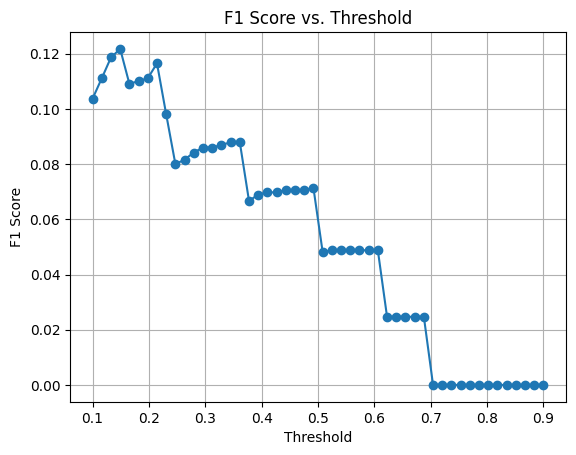

Best Threshold: 0.15 with F1 Score: 0.1217


In [50]:
import numpy as np
import matplotlib.pyplot as plt

thresholds = np.linspace(0.1, 0.9, 50)
f1s = []

for t in thresholds:
    preds = (y_pred_prob >= t).astype(int)
    f1s.append(f1_score(y_test, preds))

# Plot
plt.plot(thresholds, f1s, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.show()

best_t = thresholds[np.argmax(f1s)]
print(f"Best Threshold: {best_t:.2f} with F1 Score: {max(f1s):.4f}")


✅ 최적 Threshold: 0.15
✅ F1 Score (최적 threshold): 0.1217
✅ Accuracy: 0.9746231155778895

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3900
           1       0.20      0.09      0.12        80

    accuracy                           0.97      3980
   macro avg       0.59      0.54      0.55      3980
weighted avg       0.97      0.97      0.97      3980



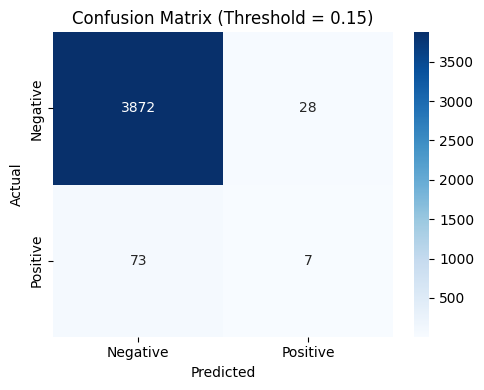

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# 1. 확률 예측
y_pred_prob = catboost_model.predict_proba(X_test)[:, 1]

# 2. 다양한 threshold에서 F1 score 계산
thresholds = np.linspace(0.1, 0.9, 50)
f1s = []

for t in thresholds:
    preds = (y_pred_prob >= t).astype(int)
    f1s.append(f1_score(y_test, preds))

# 3. 최적 threshold
best_threshold = thresholds[np.argmax(f1s)]
best_f1 = max(f1s)

# 4. 최적 threshold로 예측
y_pred_best = (y_pred_prob >= best_threshold).astype(int)

# 5. 성능 출력
print(f"✅ 최적 Threshold: {best_threshold:.2f}")
print(f"✅ F1 Score (최적 threshold): {best_f1:.4f}")
print("✅ Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

# 6. Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_threshold:.2f})")
plt.tight_layout()
plt.show()

Feature importance

/tmp/ipykernel_30/1075999890.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx[:10]], y=np.array(feature_names)[sorted_idx[:10]], palette="viridis")


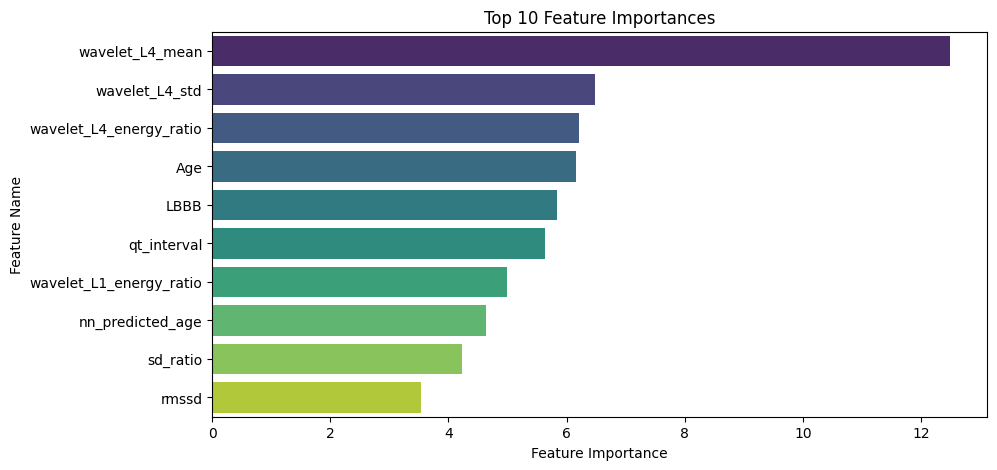

In [37]:
# feature importance
feature_names = df1.drop(columns=["Chagas_label"]).columns.tolist()
plot_feature_importance(catboost_model, feature_names)

In [38]:
# Challenge score

from helper_code import compute_challenge_score  # helper_code에서 함수 가져오기

# 모델 예측값 (확률 기반)
y_pred_prob = catboost_model.predict_proba(X_test)[:, 1]  # 모델이 1(양성)일 확률 예측

# 실제 라벨
y_true = y_test  # 실제 정답 레이블 (0 또는 1)

# ✅ Challenge Score 계산
challenge_score = compute_challenge_score(y_true, y_pred_prob)

print(f"Challenge Score: {challenge_score:.3f}")


# Challenge Score: 0.237

Challenge Score: 0.237


상관계수 높은 피처 제거

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def remove_highly_correlated_features(df, threshold=0.9):
    """
    상관계수가 threshold 이상인 피처 중 하나를 제거.
    
    Parameters:
    - df: 입력 DataFrame (수치형 피처만 포함해야 함)
    - threshold: 상관계수 기준 (default: 0.9)
    
    Returns:
    - 제거된 컬럼 목록
    - 제거 후 DataFrame
    """
    # 상관계수 행렬
    corr_matrix = df.corr().abs()

    # 상삼각행렬만 사용 (중복 제거)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # 상관계수가 threshold보다 큰 컬럼 쌍에서 하나씩 제거
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f"🔻 상관계수 {threshold} 초과로 제거된 피처 수: {len(to_drop)}")
    return to_drop, df.drop(columns=to_drop)


def plot_correlation_heatmap(df, figsize=(16, 12), threshold=0.9):
    """
    상관계수 히트맵 시각화 함수
    
    Parameters:
    - df: 수치형 피처만 포함된 DataFrame
    - figsize: 플롯 크기 설정
    - threshold: 상관계수 기준선 (선택적으로 표시)
    """
    corr = df.corr()

    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, fmt=".2f",
                cbar_kws={"shrink": 0.8}, square=True)
    plt.title("📊 Feature Correlation Heatmap", fontsize=16)
    plt.tight_layout()
    plt.show()

    # 강한 상관 피처 쌍 출력
    high_corr_pairs = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold:
                pair = (corr.columns[i], corr.columns[j], corr.iloc[i, j])
                high_corr_pairs.append(pair)

    if high_corr_pairs:
        print(f"\n🔎 상관계수 {threshold} 초과 피처쌍:")
        for feat1, feat2, corr_val in sorted(high_corr_pairs, key=lambda x: -abs(x[2])):
            print(f"  {feat1} ↔ {feat2} : {corr_val:.2f}")
    else:
        print(f"\n✅ 상관계수 {threshold} 초과 피처쌍 없음.")


/tmp/ipykernel_30/595258678.py:47: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


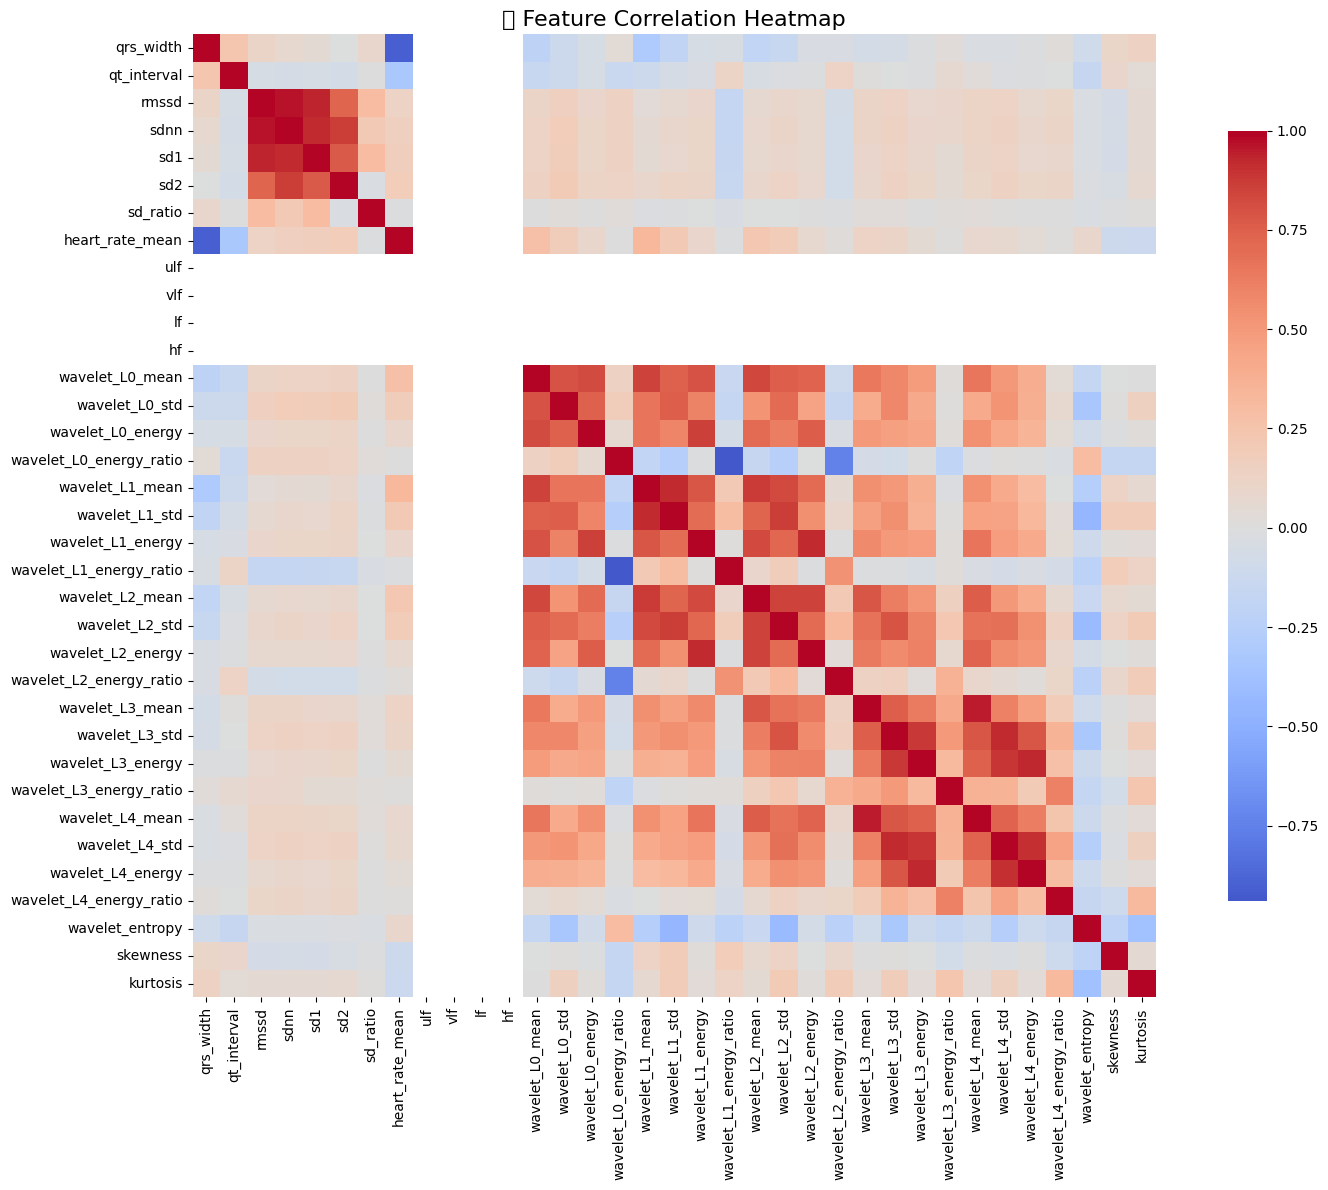


🔎 상관계수 0.9 초과 피처쌍:
  sdnn ↔ rmssd : 0.97
  wavelet_L4_mean ↔ wavelet_L3_mean : 0.95
  wavelet_L1_energy_ratio ↔ wavelet_L0_energy_ratio : -0.94
  sd1 ↔ rmssd : 0.94
  wavelet_L4_energy ↔ wavelet_L3_energy : 0.93
  wavelet_L1_std ↔ wavelet_L1_mean : 0.92
  wavelet_L4_std ↔ wavelet_L3_std : 0.92
  wavelet_L2_energy ↔ wavelet_L1_energy : 0.92
  sd1 ↔ sdnn : 0.92
  wavelet_L4_energy ↔ wavelet_L4_std : 0.91
  heart_rate_mean ↔ qrs_width : -0.91
🔻 상관계수 0.9 초과로 제거된 피처 수: 9


In [59]:
# X_numeric_scaled는 ndarray이므로 DataFrame으로 변환
X_numeric_df = pd.DataFrame(X_numeric_scaled, columns=X_numeric.columns)
plot_correlation_heatmap(X_numeric_df)

# 상관계수 기반 제거
dropped_cols, X_numeric_reduced = remove_highly_correlated_features(X_numeric_df)

# 다시 결합
X = np.hstack([X_numeric_reduced.values, X_categorical])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # 클래스 불균형 고려
)

In [56]:
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_catboost, n_trials=10)

best_params_cat = study_cat.best_params
print("최적 CatBoost 하이퍼파라미터:", best_params_cat)

[I 2025-03-27 15:36:11,763] A new study created in memory with name: no-name-70706c89-1694-4de8-9aa1-f0019eb2a57a
/tmp/ipykernel_30/1075999890.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_30/1075999890.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
/tmp/ipykernel_30/1075999890.py:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_u

최적 CatBoost 하이퍼파라미터: {'n_estimators': 839, 'depth': 5, 'learning_rate': 0.12358475702840321, 'l2_leaf_reg': 0.026933434778883915, 'bagging_temperature': 0.981304905613334}


In [62]:
catboost_model = CatBoostClassifier(
                    **best_params_cat,
                    class_weights = [1, 10],
                    verbose=0)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

# ✅ 3. CatBoost 모델 평가
y_pred_cat = catboost_model.predict(X_test)
accuracy_cat = accuracy_score(y_test, y_pred_cat)
f1_cat = f1_score(y_test, y_pred_cat)

print(f"CatBoost Accuracy: {accuracy_cat:.4f}")
print(f"CatBoost F1 Score: {f1_cat:.4f}")

# 별로 유의미하진 않았다 ,,
# CatBoost Accuracy: 0.9719
# CatBoost F1 Score: 0.0968


CatBoost Accuracy: 0.9719
CatBoost F1 Score: 0.0968


### Ensemble ver4. (deep Resnet + catboost)

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Add

# ✅ ResNet Block
def resnet_block(x, units, dropout_rate=0.3):
    shortcut = x  # Residual Connection

    x = Dense(units, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units, activation="relu")(x)
    x = BatchNormalization()(x)
    
    # Residual Connection
    x = Add()([x, shortcut])
    return x

# ✅ ResNet 모델 생성
def build_resnet(input_dim):
    inputs = Input(shape=(input_dim,))
    
    x = Dense(128, activation="relu")(inputs)
    x = resnet_block(x, 128)
    x = resnet_block(x, 128)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation="sigmoid")(x)  
    
    model = Model(inputs, x)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ✅ ResNet 모델 학습
resnet_model = build_resnet(X_train.shape[1])
resnet_model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1)

# ✅ 예측값 생성 (확률 값 사용)
resnet_train_preds = resnet_model.predict(X_train).flatten()
resnet_test_preds = resnet_model.predict(X_test).flatten()

Epoch 1/30


W0000 00:00:1743089047.904966      30 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8752 - loss: 0.3498
Epoch 2/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9798 - loss: 0.1156  
Epoch 3/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9785 - loss: 0.1206  
Epoch 4/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9793 - loss: 0.1163  
Epoch 5/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9796 - loss: 0.1077  
Epoch 6/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9810 - loss: 0.1054  
Epoch 7/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9814 - loss: 0.0997  
Epoch 8/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9802 - loss: 0.1055  
Epoch 9/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9770 - loss: 0.1179  
Epoch 10/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9777 - loss: 0.1144  
Epoch 11/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9778 - loss: 0.1142  
Epoch 12/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s

In [40]:
# ✅ ResNet 모델 Accuracy 평가 (Keras 내장 evaluate 함수 사용)
resnet_accuracy = resnet_model.evaluate(X_test, y_test, verbose=0)[1]  # [0]: loss, [1]: accuracy
resnet_preds_test = (resnet_model.predict(X_test) > 0.5).astype(int)
resnet_f1 = f1_score(y_test, resnet_preds_test)

print(f"ResNet Model Accuracy: {resnet_accuracy:.4f}")
print(f"ResNet Model F1 Score: {resnet_f1:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
ResNet Model Accuracy: 0.9799
ResNet Model F1 Score: 0.0000


Stacking 해보기

In [42]:
from catboost import CatBoostClassifier

# ✅ CatBoost 모델 학습
catboost_model = CatBoostClassifier(n_estimators=1000, depth=6, learning_rate=0.05, verbose=0)
catboost_model.fit(X_train, y_train)

# ✅ 예측값 생성 (확률 값 사용)
catboost_train_preds = catboost_model.predict_proba(X_train)[:, 1]
catboost_test_preds = catboost_model.predict_proba(X_test)[:, 1]

In [43]:
import numpy as np

# Meta 모델을 위한 새로운 입력 데이터 생성
X_train_meta = np.column_stack((resnet_train_preds, catboost_train_preds))
X_test_meta = np.column_stack((resnet_test_preds, catboost_test_preds))

# Meta Model (CatBoost) 학습
meta_model = CatBoostClassifier(n_estimators=500, depth=6, learning_rate=0.05, verbose=0)
meta_model.fit(X_train_meta, y_train)

# Meta Model 예측
meta_preds_test = meta_model.predict(X_test_meta)


In [44]:
from sklearn.metrics import accuracy_score, f1_score

meta_acc = accuracy_score(y_test, meta_preds_test)
meta_f1 = f1_score(y_test, meta_preds_test)

print(f"✅ Meta Model Accuracy: {meta_acc:.4f}")
print(f"✅ Meta Model F1 Score: {meta_f1:.4f}")

# ✅ Meta Model Accuracy: 0.9754
# ✅ Meta Model F1 Score: 0.1091

✅ Meta Model Accuracy: 0.9754
✅ Meta Model F1 Score: 0.1091


In [45]:
# Challenge score

from helper_code import compute_challenge_score  # helper_code에서 함수 가져오기

# 모델 예측값 (확률 기반)
y_pred_prob = meta_model.predict_proba(X_test)[:, 1]  # 모델이 1(양성)일 확률 예측

# 실제 라벨
y_true = y_test  # 실제 정답 레이블 (0 또는 1)

# ✅ Challenge Score 계산
challenge_score = compute_challenge_score(y_true, y_pred_prob)

print(f"Challenge Score: {challenge_score:.3f}")

# Challenge Score: 0.159

Challenge Score: 0.000


RBBB 변수 추가